In [50]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [51]:
DATASETS = [["acm", 10], ["20ng", 10], ["webkb", 10]]

CLFS_SET = [
    ["bert", "temperature_scaling"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "isotonic"],
    ["ktr", "isotonic"],
    ["lstmk", "isotonic"],
    ["lstr", "isotonic"],
    ["ltr", "isotonic"]
]
CLFS_SET.sort(key=lambda x: x[0])

FEATURES_SET = [
    "probas-based"
]

FEATURES_SET.sort()
STACKING_DIR = "/home/welton/data/stacking/stacking_output"

idx_to_clf = {idx: clf for idx, (clf, _) in enumerate(CLFS_SET)}
clf_sufix = '/'.join(sorted([ f"{c[0]}_{c[1]}" for c in CLFS_SET ]))
mf_sufix = '_'.join(sorted(FEATURES_SET))
clf_sufix, mf_sufix

('bert_temperature_scaling/ktmk_isotonic/ktr_isotonic/lstmk_isotonic/lstr_isotonic/ltr_isotonic/xlnet_temperature_scaling',
 'probas-based')

ACM;0.5;0.9326206071249636;0.8293263158366774;16485;3392;1191;3829
ACM;0.6;0.9194883657158428;0.8760713579080557;17414;2463;1525;3495
ACM;0.7;0.9010912804909855;0.9275502693524306;18437;1440;2025;2995
ACM;0.8;0.8746247552492905;0.9717593261670366;19315;562;2773;2247
ACM;0.9;0.8465197054972109;0.9976421388928237;19830;47;3596;1424
20NG;0.5;0.9772934364679216;0.9372325365752969;15878;1064;369;1535
20NG;0.6;0.9706378414122806;0.9597222902703161;16259;683;492;1412
20NG;0.7;0.9633038524277012;0.9757086031559601;16530;412;630;1274
20NG;0.8;0.9525273039319266;0.9899726579856434;16772;170;836;1068
20NG;0.9;0.9407795599856783;0.998642215936483;16919;23;1065;839
WEBKB;0.5;0.9392326413679604;0.9072077359135895;6208;633;402;956
WEBKB;0.6;0.9254387889602844;0.9424316179634749;6448;393;519;839
WEBKB;0.7;0.9143837326731898;0.9651194115336896;6603;238;618;740
WEBKB;0.8;0.9038921491859835;0.9780245846347879;6691;150;712;646
WEBKB;0.9;0.8737610927488346;0.9969212995527652;6820;21;985;373


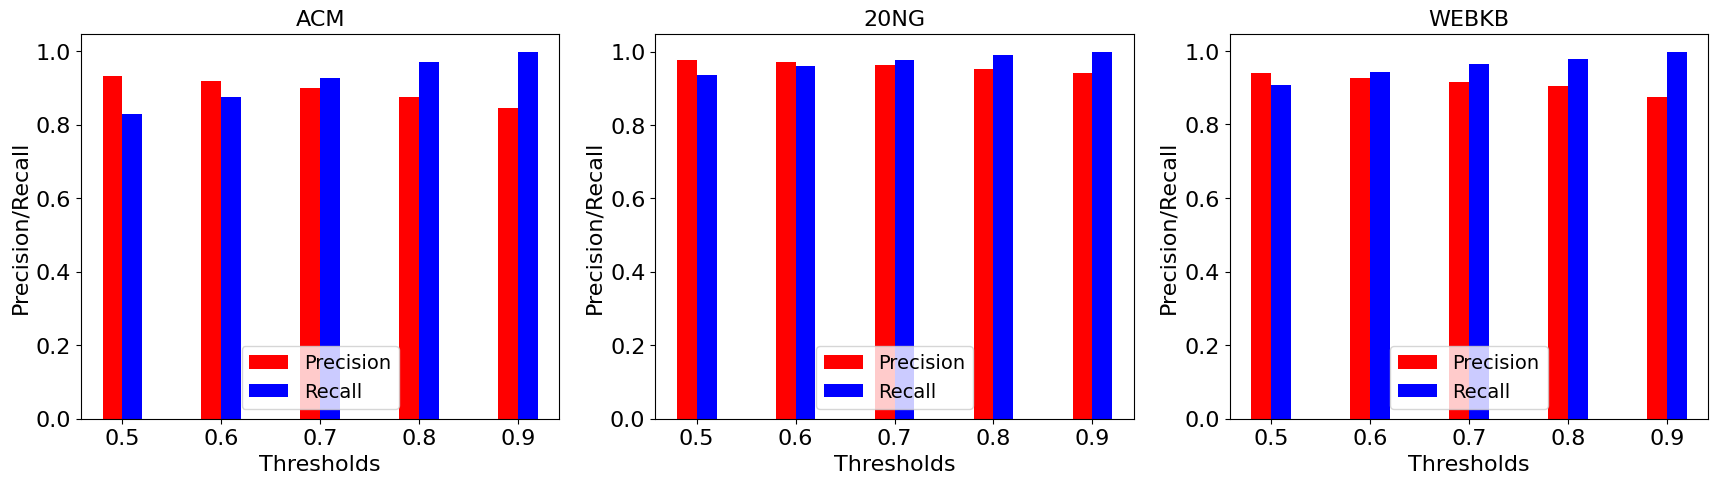

In [55]:
tresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
plt.figure(figsize=(21, 5))
precision, recall, matrix = {}, {}, {}
mms = {}
for plot_idx, (dataset, n_folds) in enumerate(DATASETS):
    precs, recs = [], []
    mms[dataset] = []
    for cut_pos, cut_score in enumerate(tresholds):
        rows = []
        precision[dataset] = []
        recall[dataset] = []
        matrix[dataset] = []
        for fold in np.arange(n_folds):
            base_dir = f"{STACKING_DIR}/{dataset}/{n_folds}_folds/logistic_regression/hard_docs/{clf_sufix}/{mf_sufix}/fold_{fold}"
            loader = np.load(f"{base_dir}/output.npz")
            
            preds = loader["detect_probs"].copy()
            preds[preds >= cut_score] = 1
            preds[preds < cut_score] = 0

            y = loader["test_counts"].copy()
            y[y < 4] = 1
            y[y > 3] = 0

            precision[dataset].append(precision_score(y, preds, pos_label=0))
            recall[dataset].append(recall_score(y, preds, pos_label=0))
            matrix[dataset].append(confusion_matrix(y, preds).ravel())
        
        prec = np.mean(precision[dataset])
        rec = np.mean(recall[dataset])
        mm = np.sum(matrix[dataset], axis=0).tolist()
        mms[dataset].append(mm)
        #plt.subplot(1, 3, plot_idx + 1)
        #plt.bar([cut_pos, cut_pos + 0.2], [prec, rec], width=0.2, color='blue')
        precs.append(prec)
        recs.append(rec)
        
        ravel = ';'.join([ str(m) for m in mm ])
        print(f"{dataset.upper()};{cut_score};{prec};{rec};{ravel}")
    
    plt.subplot(1, 3, plot_idx + 1)
    xp = np.arange(len(precs))
    xr = xp + 0.2
    plt.bar(xp, precs, color='red', label='Precision', width=0.2)
    plt.bar(xr, recs, color='blue', label='Recall', width=0.2)
    _ = plt.xticks(ticks=xp+0.1, labels=[0.5, 0.6, 0.7, 0.8, 0.9], fontsize=16)
    _ = plt.yticks(fontsize=16)
    _ = plt.xlabel("Thresholds", fontsize=16)
    _ = plt.ylabel("Precision/Recall", fontsize=16)
    _ = plt.title(dataset.upper(), fontsize=16)
    plt.legend(fontsize=14)



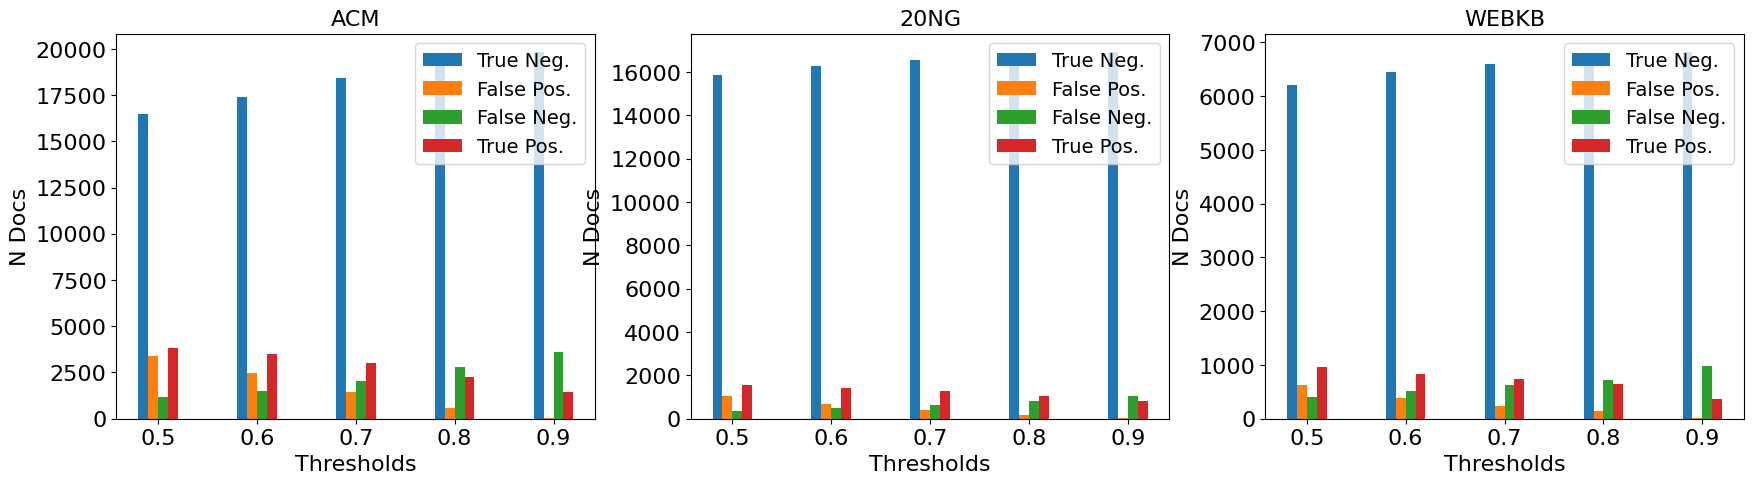

In [58]:
legends = ["True Neg.", "False Pos.", "False Neg.", "True Pos."]
plt.figure(figsize=(21, 5))
for plot_idx, dataset in enumerate(mms):
    dm = np.array(mms[dataset])
    for cut_idx in np.arange(dm.shape[1]):
        y = dm[:, cut_idx]
        x = np.arange(len(y))
        plt.subplot(1, 3, plot_idx + 1)
        xa = (x - 0.5) + 0.5 + cut_idx * 0.1
        plt.bar(xa, y, width=0.1, label=legends[cut_idx])
    plt.xticks(ticks=np.arange(dm.shape[0]) + 0.15, labels=tresholds, fontsize=16)
    _ = plt.yticks(fontsize=16)
    _ = plt.xlabel("Thresholds", fontsize=16)
    _ = plt.ylabel("N Docs", fontsize=16)
    _ = plt.title(dataset.upper(), fontsize=16)
    plt.legend(fontsize=14)

In [34]:
dm[0]

array([6208,  633,  402,  956])